## QAE using Maximum Liklehood Estimation

In [3]:
## imports
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer,providers
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.algorithms import AmplitudeEstimation
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import numpy as np
from numpy import pi
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt

In [4]:
# setup simulator using IBM_id
# IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm_simulator = Aer.get_backend('qasm_simulator')
stv_simulator = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')

In [5]:
# sub-routines for QPE ~
def crot(qc, l):
    if l == 0:
        return qc
    l = l-1
    qc.h(l)
    for q in range(l):
        qc.cp(pi/2**(l-q), q, l)
    #qc.barrier()
    # qc.draw()
    
def QFT(qc):
   """function to generate QFT circuit """
   dim = qc.num_qubits
   for q in range(dim):
      crot(qc, dim-q)
   for q in range(int(dim/2)):
      qc.swap(q, dim-q-1)

   #qc.draw()
   return qc
   

In [6]:
## sub-routines for Grover Search ~
def to_oracle(pattern, name= 'oracle'):
    """ convert a given pattern to an oracle
    pattern~ a numpy vector with binarry entries """
    l = len(pattern)
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    qc = QuantumCircuit(qr, a, name= name+str(pattern))
    for q in range(l):
        if(pattern[q]==0): qc.x(qr[q])
    qc.x(a)
    qc.h(a)
    qc.mcx(qr, a)
    qc.h(a)
    qc.x(a)
    for q in range(l):
        if(pattern[q]==0): qc.x(qr[q])
    #qc.barrier()
    return qc.to_gate()

def diffuser(l):
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    circuit = QuantumCircuit(qr, a, name= 'Diff.')
    circuit.h(qr)
    circuit.x(qr)
    circuit.x(a)
    circuit.h(a)
    circuit.mcx(qr ,a)
    circuit.h(a)
    circuit.x(a)
    circuit.x(qr)
    circuit.h(qr)    
    return circuit.to_gate()

def grover_iterate(qc, oracles, diffuser, qreg_u, ancilla, steps):
    for step in range(steps):
        for oracle in oracles:
            qc.append(oracle, list(range(qc.num_qubits)) )
        qc.append(diffuser, list([q for q in qreg_u])+ list(ancilla) )
        # qc.barrier()
    return qc

## sub-routine for grover ~
def grover(patterns, grover_steps):
    
    dim = len(patterns[0])
    
    # create oracles ~\
    oracles = []
    for pattern in patterns : oracles.append( to_oracle(pattern)) 
    
    # create diffuser ~\
    diff = diffuser(dim)

    # create circuit ~\
    qreg = QuantumRegister(dim, name= 'init')
    ancilla = AncillaRegister(1, name='ancilla')
    qc = QuantumCircuit(qreg, ancilla, name='grover'+'^'+str(grover_steps))
    qc = grover_iterate(qc, oracles, diff, qreg, ancilla,grover_steps)
  
    return qc

# def run(patterns, grover_steps ):

#     dim = len(patterns[0])
#     # create oracles ~\
#     oracles = []
#     for pattern in patterns : oracles.append( to_oracle(pattern)) 
    
#     # create diffuser ~\
#     diff = diffuser(dim)
#     # create circuit ~\
    
#     qreg = QuantumRegister(dim, name= 'init')
#     ancilla = AncillaRegister(1, name='ancilla')
#     creg = ClassicalRegister(dim)
#     qc = QuantumCircuit(qreg, creg, ancilla)
#     qc.h(qreg)
#     # run grover update steps ~\
#     grover_iterate(qc, oracles, diff, qreg, ancilla,grover_steps)
#     qc.measure(qreg, creg)
    
#     job = execute(qc, backend= aer, shots= 1024)
#     plot_histogram(job.result().get_counts())
    
#     return qc, job


## 1 Qubit example

## QPE ~


In [10]:
## operator preparation ~
def s_psi0(p):
    qc = QuantumCircuit(1, name= " S_psi0 ")
    theta = 2*np.arcsin(np.sqrt(p))
    qc.ry(theta, 0)

    return qc.to_gate()
    
def Q(p, power):
    theta = 2*np.arcsin(np.sqrt(p))
    qc = QuantumCircuit(1, name= ' Q'+ '^'+ str(power) )
    qc.ry(2*theta*power, 0)

    return qc.to_gate()
    


In [11]:
## set p ~
p = 0.685

precision = 4
preg = QuantumRegister(precision, name= 'precisio_q')
qreg = QuantumRegister(1, name='qreg')
creg = ClassicalRegister(precision, name='precision_c')
qc = QuantumCircuit(preg,qreg, creg)

qc.h(preg)
qc.append(s_psi0(p), [precision] )
qc.barrier()
for q in range(precision):
    qc.append(Q(p,2**q).control(1), [q]+list(range(precision,precision+1)) )

qftgate_inv = QFT(QuantumCircuit(precision, name='QFT')).to_gate().inverse()
qc.barrier()
qc.append(qftgate_inv, list(range(precision)))


qc.draw()

┌───┐     ░                                  ░ ┌─────────┐
 precisio_q_0: ───┤ H ├─────░────■─────────────────────────────░─┤0        ├
                  ├───┤     ░    │                             ░ │         │
 precisio_q_1: ───┤ H ├─────░────┼───────■─────────────────────░─┤1        ├
                  ├───┤     ░    │       │                     ░ │  QFT_dg │
 precisio_q_2: ───┤ H ├─────░────┼───────┼───────■─────────────░─┤2        ├
                  ├───┤     ░    │       │       │             ░ │         │
 precisio_q_3: ───┤ H ├─────░────┼───────┼───────┼───────■─────░─┤3        ├
               ┌──┴───┴───┐ ░ ┌──┴───┐┌──┴───┐┌──┴───┐┌──┴───┐ ░ └─────────┘
         qreg: ┤  S_psi0  ├─░─┤  Q^1 ├┤  Q^2 ├┤  Q^4 ├┤  Q^8 ├─░────────────
               └──────────┘ ░ └──────┘└──────┘└──────┘└──────┘ ░            
precision_c: 4/═════════════════════════════════════════════════════════════

In [12]:
qc.measure(preg, creg)
job = execute(qc, backend= aer, shots= 2000)
counts = job.result().get_counts()


## estimate p ~
estimate = sorted(zip(counts.values(), counts.keys()), reverse= True)
for p in range(2): print('p = ',(np.sin(int(estimate[p][1], 2)*pi/(2**precision)))**2 )

p =  0.6913417161825449
p =  0.6913417161825453


## MLE ~

In [13]:
## estimation sub-routine
def likelihood(n,m, shots, thetas= np.linspace(0, 2*pi, 100)):
    dic = {}
    for theta in thetas: 
        dic[theta] = (((np.sin((2*m+1)*theta))**2)**n)*(((np.cos((2*m+1)*theta))**2)**(shots-n)) 
    return dic

def combine_likelihood(lkhs):
    dic = lkhs[0]
    for lkh in lkhs[1:]: 
        for theta in lkh.keys():
            dic[theta] = dic[theta]*lkh[theta]
            
    return dic
    

In [14]:
def generate_le(p,q= 1, shots= 100, thetas= np.linspace(0, 2*pi, 50, endpoint= False)):
    # p = 0.3
    # q = 1
    # shots = 100

    qreg = QuantumRegister(1, name= 'qreg')
    creg = ClassicalRegister(1, name= 'creg')
    qc = QuantumCircuit(qreg, creg )

    qc.append(s_psi0(p),[0])
    qc.barrier()
    qc.append(Q(p, q), [0])

    qc.measure(qreg, creg)
    counts =  execute(qc, backend= aer, shots = shots).result().get_counts()
    le = likelihood(counts['1'],q,shots,thetas= thetas)

    return le
    

In [28]:
## set p 
p = 0.3

## set values of q for which observation is required
qs= [1,4,8]

## generatte liklihoods for q in qs
les = [ generate_le(p, q= q, shots= 50 ) for q in qs ]

In [29]:
les_f = combine_likelihood(les)

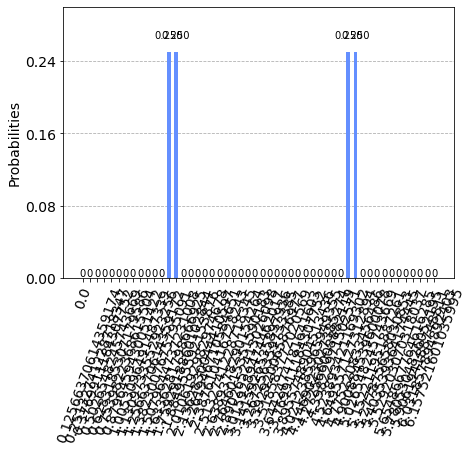

In [30]:
plot_histogram(les_f)

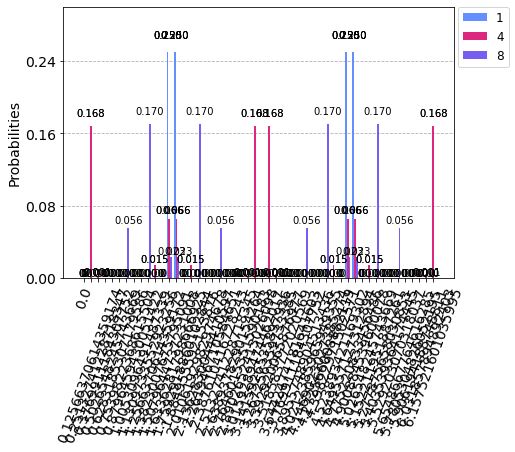

In [31]:
plot_histogram(les, legend = [str(i) for i in qs ])

In [32]:
estimate = sorted(zip(les_f.values(), les_f.keys()), reverse= True)
for p in range(10): print('theta = ',estimate[p][1] ), print(' p = ', (np.sin(estimate[p][1]))**2 ) 

theta =  4.649557127312894
 p =  0.9960573506572389
theta =  4.775220833456486
 p =  0.9960573506572389
theta =  1.6336281798666925
 p =  0.9960573506572389
theta =  1.5079644737231008
 p =  0.9960573506572389
theta =  5.7805304826052195
 p =  0.23208660251050173
theta =  3.6442474781641603
 p =  0.23208660251050178
theta =  0.5026548245743669
 p =  0.23208660251050173
theta =  2.6389378290154264
 p =  0.23208660251050164
theta =  5.026548245743669
 p =  0.9045084971874738
theta =  1.2566370614359172
 p =  0.9045084971874736


Scratch


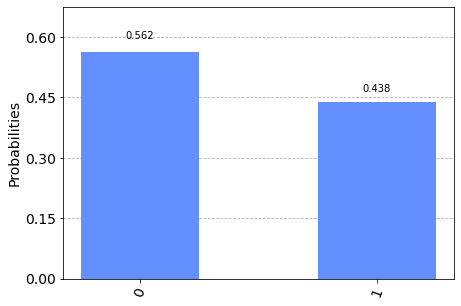

In [66]:
## set p ~
p = 0.45

qreg = QuantumRegister(1, name= 'qreg')
creg = ClassicalRegister(1, name= 'creg')
qc = QuantumCircuit(qreg, creg )

## 
qc.append(s_psi0(p),[0])
qc.barrier()
# shots= 1000
qc.measure(qreg, creg)
counts =  execute(qc, backend= aer, shots = 500).result().get_counts()
plot_histogram(counts)

In [71]:
q = 1
shots = 500

qreg = QuantumRegister(1, name= 'qreg')
creg = ClassicalRegister(1, name= 'creg')
qc = QuantumCircuit(qreg, creg )

qc.append(s_psi0(p),[0])
qc.barrier()


qc.append(Q(p, q), [0])

qc.draw(output= 'text')


┌──────────┐ ░ ┌──────┐
  qreg: ┤  S_psi0  ├─░─┤  Q^1 ├
        └──────────┘ ░ └──────┘
creg: 1/═══════════════════════

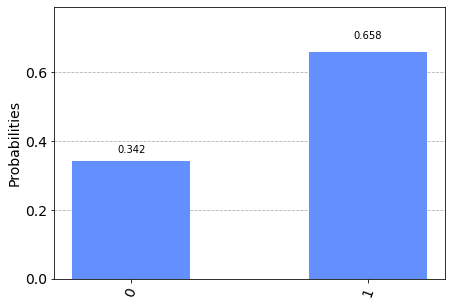

In [72]:
qc.measure(qreg, creg)
counts =  execute(qc, backend= aer, shots = shots).result().get_counts()
plot_histogram(counts)

In [73]:
le = likelihood(counts['1'],q,shots,thetas= np.linspace(0, 2*pi, 50, endpoint= False))

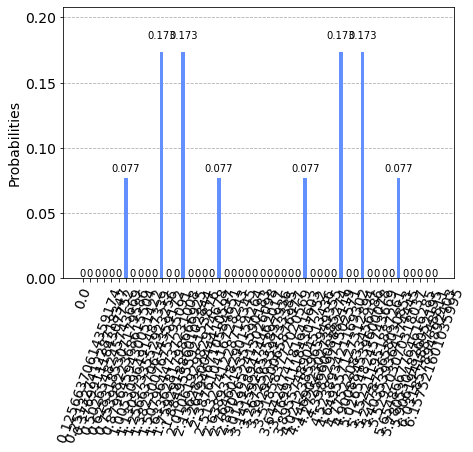

In [74]:
plot_histogram(le)

In [75]:
estimate = sorted(zip(le.values(), le.keys()), reverse= True)
for p in range(8): print('theta = ',estimate[p][1] ), print(' p = ', (np.sin(estimate[p][1]))**2 ) 

theta =  4.900884539600078
 p =  0.9648882429441256
theta =  1.7592918860102844
 p =  0.9648882429441256
theta =  1.3823007675795091
 p =  0.9648882429441258
theta =  4.523893421169302
 p =  0.9648882429441258
theta =  5.529203070318037
 p =  0.46860474023534276
theta =  0.7539822368615504
 p =  0.4686047402353434
theta =  2.387610416728243
 p =  0.4686047402353431
theta =  3.8955748904513436
 p =  0.4686047402353434


## Multiple Qubit Case

In [68]:
def generate_le_multi(patterns, q=1, shots= 100, thetas= np.linspace(0, 2*pi, 100, endpoint= False) ):
   
    d = len(patterns[0])
    good_states = [ ''.join([str(elem) for elem in pattern]) for pattern in patterns      ]

    qreg = QuantumRegister(d, name= 'qreg')
    ancilla = AncillaRegister(1, name= 'ancilla')
    creg = ClassicalRegister(d, name= 'creg')
    qc = QuantumCircuit(qreg, ancilla, creg)

    qc.h(qreg)
    qc.append(grover(patterns, q).to_gate(), list(range(d+1)) )
    
    
    qc.measure(qreg, creg)
    counts =  execute(qc, backend= aer, shots = shots).result().get_counts()
    good_counts = sum([counts[state] for state in good_states ])
    le = likelihood(good_counts,q,shots,thetas= thetas)

    return le, good_counts

In [71]:
patterns = [[0,1,0]]
# patterns = [[0,1,1,1],[0,0,1,0],[1,0,1,1]]
good_states = [ ''.join([str(elem) for elem in pattern]) for pattern in patterns      ]

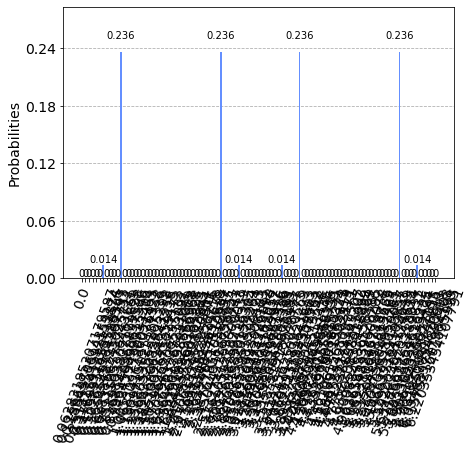

In [72]:
le = generate_le_multi(patterns ,q= 1 , shots= 1000)
plot_histogram(le[0])

In [73]:
le[1]

785

In [67]:
estimate = sorted(zip(le.values(), le.keys()), reverse= True)
for p in range(6): print('theta = ',estimate[p][1] ), print(' p = ', (np.sin(estimate[p][1]))**2 ) 

theta =  5.592034923389832
 p =  0.4063093427071376
theta =  2.450442269800039
 p =  0.4063093427071374
theta =  0.6911503837897546
 p =  0.40630934270713776
theta =  3.832743037379548
 p =  0.40630934270713803
theta =  2.7646015351590183
 p =  0.13551568628929408
theta =  0.3769911184307752
 p =  0.13551568628929425


Scratch

In [61]:
## implementation ~
q= 1
d = len(patterns[0])
good_states = [ ''.join([str(elem) for elem in pattern]) for pattern in patterns      ]

qreg = QuantumRegister(d, name= 'qreg')
ancilla = AncillaRegister(1, name= 'ancilla')
creg = ClassicalRegister(d, name= 'creg')
qc = QuantumCircuit(qreg, ancilla, creg)

qc.h(qreg)
qc.append(grover(patterns, q).to_gate(), list(range(d+1)) )


qc.measure(qreg, creg)
counts =  execute(qc, backend= aer, shots = 1024).result().get_counts()

qc.draw()
# good_counts = sum([counts[state] for state in good_states ])
# le = likelihood(good_counts,q,shots,thetas= thetas)


┌───┐┌───────────┐┌─┐      
 qreg_0: ┤ H ├┤0          ├┤M├──────
         ├───┤│           │└╥┘┌─┐   
 qreg_1: ┤ H ├┤1          ├─╫─┤M├───
         ├───┤│  grover^1 │ ║ └╥┘┌─┐
 qreg_2: ┤ H ├┤2          ├─╫──╫─┤M├
         └───┘│           │ ║  ║ └╥┘
ancilla: ─────┤3          ├─╫──╫──╫─
              └───────────┘ ║  ║  ║ 
 creg: 3/═══════════════════╩══╩══╩═
                            0  1  2

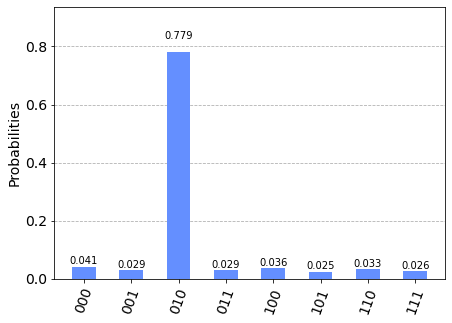

In [62]:
plot_histogram(counts)